# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
# Imports
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import project_tests as t

sns.set_theme(context="talk", style="darkgrid")
import time
from pprint import pprint

np.random.seed(41)

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/cb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Read in data
df = pd.read_csv("data/user-item-interactions.csv")
df_content = pd.read_csv("data/articles_community.csv")
del df["Unnamed: 0"]
del df_content["Unnamed: 0"]

# import the user_item_matrix
uim = pd.read_pickle("user_item_matrix.p")

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

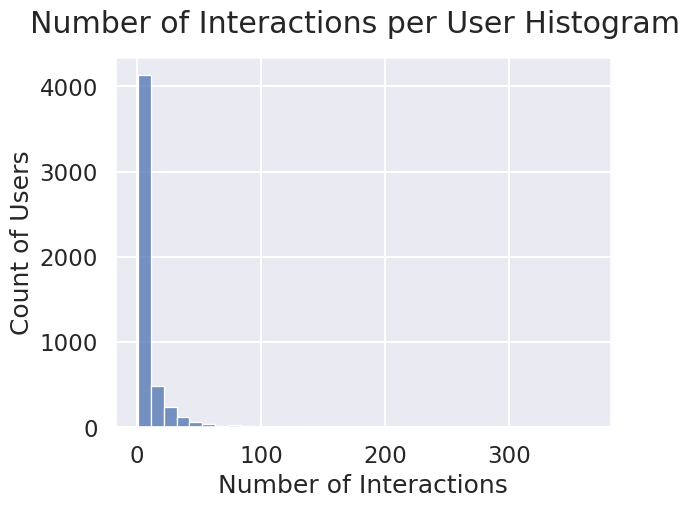

In [4]:
# user_interaction_count = uim.sum(axis=1) # number of interactions per user
user_interaction_count = df.groupby("email").count()[
    "article_id"
]  # number of interactions per user
fig, ax = plt.subplots()
sns.histplot(x=user_interaction_count, kde=False, bins="rice", ax=ax)
fig.suptitle("Number of Interactions per User Histogram")
ax.set_xlabel("Number of Interactions")
ax.set_ylabel("Count of Users");

In [5]:
# Fill in the median and maximum number of user_article interactions below

median_val = int(
    np.median(user_interaction_count)
)  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = int(
    np.max(user_interaction_count)
)  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
df_content["article_id"].value_counts()

article_id
221     2
232     2
50      2
398     2
577     2
       ..
357     1
358     1
359     1
360     1
1050    1
Name: count, Length: 1051, dtype: int64

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates("article_id", inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
unique_articles = len(
    df["article_id"].value_counts()
)  # The number of unique articles that have at least one interaction
total_articles = int(
    len(df_content)
)  # The number of unique articles on the IBM platform
unique_users = df["email"].nunique()  # The number of unique users
user_article_interactions = len(df)  # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [9]:
most_viewed_article_id = str(
    df["article_id"].value_counts(dropna=False).idxmax()
)  # The most viewed article in the dataset as a string with one value following the decimal
max_views = (
    df["article_id"].value_counts(dropna=False).max()
)  # The most viewed article in the dataset was viewed how many times?

In [10]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column


def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df["email"]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])
    return email_encoded


email_encoded = email_mapper()
del df["email"]
df["user_id"] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above,
## you shouldn't need to change anything in this cell

sol_1_dict = {
    "`50% of individuals have _____ or fewer interactions.`": median_val,
    "`The total number of user-article interactions in the dataset is ______.`": user_article_interactions,
    "`The maximum number of user-article interactions by any 1 user is ______.`": max_views_by_user,
    "`The most viewed article in the dataset was viewed _____ times.`": max_views,
    "`The article_id of the most viewed article is ______.`": most_viewed_article_id,
    "`The number of unique articles that have at least 1 rating ______.`": unique_articles,
    "`The number of unique users in the dataset is ______`": unique_users,
    "`The number of unique articles on the IBM platform`": total_articles,
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [12]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    """
    # Your code here
    # get titles for top n article ids
    titles_by_article_id = df.loc[df["article_id"].isin(get_top_article_ids(n))][
        "title"
    ]

    # use sets to get unique titles and then change to a list
    top_articles = set(titles_by_article_id)
    top_articles = list(top_articles)

    return top_articles  # Return the top article titles from df (not df_content)


def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    """
    # Your code here
    top_articles = df["article_id"].value_counts().index
    top_articles = list(top_articles[0:n])

    return top_articles  # Return the top article ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'insights from new york car accident reports', 'apache spark lab, part 1: basic concepts', 'visualize car data with brunel', 'healthcare python streaming application demo']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's


def create_user_item_matrix(df):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with
    an article and a 0 otherwise
    """
    # Fill in the function here
    # nunique will count the unique titles for a user_id + article ID combination (will always be 1)
    # then unstack will pivot the article id index level to columns.

    user_item = (
        df.groupby(["user_id", "article_id"])["title"].nunique().unstack(fill_value=0.0)
    )

    return user_item  # return the user_item matrix


user_item = create_user_item_matrix(df)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert (
    user_item.shape[0] == 5149
), "Oops!  The number of users in the user-article matrix doesn't look right."
assert (
    user_item.shape[1] == 714
), "Oops!  The number of articles in the user-article matrix doesn't look right."
assert (
    user_item.sum(axis=1)[1] == 36
), "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    """
    # compute similarity of each user to the provided user
    dot_prod_users = np.dot(user_item.loc[user_id], user_item.T)
    similarity_series = pd.Series(data=dot_prod_users, index=user_item.index)

    # sort by similarity
    similarity_series.sort_values(ascending=False, inplace=True)

    # remove the own user's id
    similarity_series.drop(user_id, inplace=True)

    # create list of just the ids
    most_similar_users = list(similarity_series.index)
    similarity_score = list(similarity_series.values)

    return (
        most_similar_users,
        similarity_score,
    )  # return a list of the users in order from most to least similar

In [18]:
# Do a spot check of your function
print(
    "The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[0][:10])
)
print(
    "The 5 most similar users to user 3933 are: {}".format(
        find_similar_users(3933)[0][:5]
    )
)
print(
    "The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[0][:3])
)

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column)
    """
    # Your code here
    # change strings to floats to pass assertion tests
    article_ids = [float(i) for i in article_ids]

    unique_article_names = set(df.loc[df["article_id"].isin(article_ids)]["title"])

    article_names = list(unique_article_names)

    return article_names  # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the doc_full_name column in df_content)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Your code here
    user_series = user_item.loc[user_id]  # series for just that user
    article_ids = user_series.loc[
        user_series == 1
    ]  # only get if user interacted with that article
    article_ids = list(
        article_ids.index
    )  # get the index which contains the article ids
    article_ids = [str(i) for i in article_ids]  # purely to pass assertion tests

    # get article names based on ids
    article_names = get_article_names(article_ids)

    return article_ids, article_names  # return the ids and names


def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily

    """
    # Your code here
    user_article_ids, _ = get_user_articles(user_id)
    user_article_ids = np.array(user_article_ids)

    recs = []  # initialize rec list
    for neighbor in find_similar_users(user_id)[0]:
        neighbor_article_ids, _ = get_user_articles(neighbor)
        neighbor_article_ids = np.array(neighbor_article_ids)
        new_to_user = np.setdiff1d(neighbor_article_ids, user_article_ids)
        if new_to_user.size > 0:
            # add titles to recs if they do not already exist in recs
            recs.extend(np.setdiff1d(new_to_user, np.array(recs)))
            if len(recs) >= m:
                break

    return recs[:m]  # return your recommendations for this user_id

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10))  # Return 10 recommendations for user 1

['data tidying in data science experience',
 'airbnb data for analytics: mallorca reviews',
 'a tensorflow regression model to predict house values',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'recommender systems: approaches & algorithms',
 'analyze facebook data using ibm watson and watson studio',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'airbnb data for analytics: vancouver listings']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(
    get_article_names(["1024.0", "1176.0", "1305.0", "1314.0", "1422.0", "1427.0"])
) == set(
    [
        "using deep learning to reconstruct high-resolution audio",
        "build a python app on the streaming analytics service",
        "gosales transactions for naive bayes model",
        "healthcare python streaming application demo",
        "use r dataframes & ibm watson natural language understanding",
        "use xgboost, scikit-learn & ibm watson machine learning apis",
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(["1320.0", "232.0", "844.0"])) == set(
    [
        "housing (2015): united states demographic measures",
        "self-service data preparation with ibm data refinery",
        "use the cloudant-spark connector in python notebook",
    ]
), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(["1320.0", "232.0", "844.0"])
assert set(get_user_articles(20)[1]) == set(
    [
        "housing (2015): united states demographic measures",
        "self-service data preparation with ibm data refinery",
        "use the cloudant-spark connector in python notebook",
    ]
)
assert set(get_user_articles(2)[0]) == set(
    ["1024.0", "1176.0", "1305.0", "1314.0", "1422.0", "1427.0"]
)
assert set(get_user_articles(2)[1]) == set(
    [
        "using deep learning to reconstruct high-resolution audio",
        "build a python app on the streaming analytics service",
        "gosales transactions for naive bayes model",
        "healthcare python streaming application demo",
        "use r dataframes & ibm watson natural language understanding",
        "use xgboost, scikit-learn & ibm watson machine learning apis",
    ]
)
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
# calculate number of interactions by user_id
num_interactions = (
    df[["user_id", "article_id"]].groupby("user_id", sort=False, as_index=False).count()
)
num_interactions.rename(columns={"article_id": "num_interactions"}, inplace=True)
num_interactions.head()

,user_id,num_interactions
0,1,47
1,2,6
2,3,82
3,4,45
4,5,5


In [23]:
def get_top_sorted_users(
    user_id, df=df, user_item=user_item, num_interactions=num_interactions
):
    """
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise
    num_interactions - (pandas dataframe) this is the number of interactions per user.
            This will be used to break ties on similarity.


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where
                    highest of each is higher in the dataframe

    """
    # Your code here

    # create a dataframe containing the users that are similar along with similarity score
    similar_users = find_similar_users(user_id)[0]
    similar_user_score = find_similar_users(user_id)[1]
    similarity_df = pd.DataFrame(
        {"neighbor_id": similar_users, "similarity": similar_user_score}
    )

    # join in the number of interactions for each neighbor
    neighbors_df = similarity_df.merge(
        num_interactions, how="left", left_on="neighbor_id", right_on="user_id"
    )
    neighbors_df.drop(columns=["user_id"], inplace=True)
    neighbors_df.sort_values(
        by=["similarity", "num_interactions"], ascending=[False, False], inplace=True
    )

    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, df=df):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    """
    # Your code here

    user_article_ids, _ = get_user_articles(user_id)
    user_article_ids = np.array(user_article_ids)
    top_articles = get_top_article_ids(len(df))

    # list of closes users
    closest_neighbors = list(get_top_sorted_users(user_id)["neighbor_id"])

    recs = []  # initialize rec list
    for neighbor in closest_neighbors:
        neighbor_article_ids, _ = get_user_articles(neighbor)
        neighbor_article_ids = np.array(neighbor_article_ids)
        new_to_user = np.setdiff1d(neighbor_article_ids, user_article_ids)
        if new_to_user.size > 0:
            # sort the list by most interacted
            new_to_user = sorted(
                new_to_user, key=lambda rec: top_articles.index(float(rec))
            )

            # add titles to recs if they do not already exist in recs
            recs.extend(np.setdiff1d(new_to_user, np.array(recs)))
        if len(recs) >= m:
            break

    rec_names = get_article_names([float(i) for i in recs[:m]], df)

    return recs[:m], rec_names

In [24]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'analyze accident reports on amazon emr spark', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: venice listings', 'tensorflow quick tips', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: chicago listings', 'airbnb data for analytics: venice calendar']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [25]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)["neighbor_id"].iloc[
    0
]  # Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users(131)["neighbor_id"].iloc[
    9
]  # Find the 10th most similar user to user 131

In [26]:
## Dictionary Test Here
sol_5_dict = {
    "The user that is most similar to user 1.": user1_most_sim,
    "The user that is the 10th most similar to user 131": user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

If we were given a new user, the function get_top_articles (or get_top_article_ids) could be used to make recommendations.  This would just return the articles with the most interactions.  This may not be the best way because we have no information on what types of artilces the new user may be interested in.

One better way to make recommendations for a new user would be to use Knowledge Based Recommendations.  Using this method would allow the new user to filter the top recommendations based on things like key words in the title, doc_description.  We could also use text analysis machine learning on the doc_body field to further categorize the documents and then allow the user to filter on these newly created catgeories.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [27]:
new_user = "0.0"

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
new_user_recs = [
    str(i) for i in get_top_article_ids(10)
]  # convert to string to pass test

In [28]:
assert set(new_user_recs) == set(
    [
        "1314.0",
        "1429.0",
        "1293.0",
        "1427.0",
        "1162.0",
        "1364.0",
        "1304.0",
        "1170.0",
        "1431.0",
        "1330.0",
    ]
), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [29]:
# write a tokenization function to process doc
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))
pattern = re.compile(r"[^a-zA-Z0-9]")


def tokenize(text):
    text = pattern.sub(" ", text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w, pos="v") for w in tokens if w not in stop_words]

    return tokens

In [30]:
# build a pipeline
vectorizer = CountVectorizer(tokenizer=tokenize, token_pattern=None, lowercase=True)
tfidf = TfidfTransformer()
lsa = TruncatedSVD(n_components=100, random_state=41)  # keep 100 components

preprocesser = Pipeline([("vect", vectorizer), ("tfidf", tfidf), ("lsa", lsa)])

In [31]:
# build X Matrix
X = np.array(df_content["doc_body"].fillna(" "))

In [32]:
# transform data
X_new = preprocesser.fit_transform(X)

In [33]:
# fit clusters
start = time.time()
# keep scores
scores = []  # these will be the silhouette scores (higher is better)
squared_dist_scores = (
    []
)  # these will be the kmeans score of average squared distance to closets centroid (lower is better)
num_clusters = []

# test up to ~150 clusters
# iterate over clusters, fit a KMeans and record the scores for visual charting
n_clusters = np.arange(10, 150, 10)
for cluster in n_clusters:
    fit_start = time.time()
    print(f"Testing with num clusters={cluster}.")
    kmeans = KMeans(n_clusters=cluster, n_init="auto", random_state=41)
    labels = kmeans.fit_predict(X_new)  # these are the predicted cluster labels

    # track the scores and number of clusters
    score = silhouette_score(X_new, labels)
    squared_score = (kmeans.score(X_new) * -1) / len(X_new)
    squared_dist_scores.append(squared_score)
    scores.append(score)
    num_clusters.append(cluster)
    fit_end = time.time()

    # preint results
    print(
        f"That specific fit took {(fit_end - fit_start):.2f} seconds. silhouette_score: {score:.2f}, average squared distance to closest centroid {squared_score:.2f}"
    )


end = time.time()
total = end - start
print(f"Total complete in {total:.2f} seconds.")

Testing with num clusters=10.
That specific fit took 0.20 seconds. silhouette_score: 0.10, average squared distance to closest centroid 0.29
Testing with num clusters=20.
That specific fit took 0.13 seconds. silhouette_score: 0.14, average squared distance to closest centroid 0.25
Testing with num clusters=30.
That specific fit took 0.04 seconds. silhouette_score: 0.15, average squared distance to closest centroid 0.22
Testing with num clusters=40.
That specific fit took 0.04 seconds. silhouette_score: 0.16, average squared distance to closest centroid 0.20
Testing with num clusters=50.
That specific fit took 0.05 seconds. silhouette_score: 0.18, average squared distance to closest centroid 0.18
Testing with num clusters=60.
That specific fit took 0.04 seconds. silhouette_score: 0.20, average squared distance to closest centroid 0.16
Testing with num clusters=70.
That specific fit took 0.08 seconds. silhouette_score: 0.21, average squared distance to closest centroid 0.15
Testing with 

Examine the resulting clusters Silhouette Scores and Distance Scores

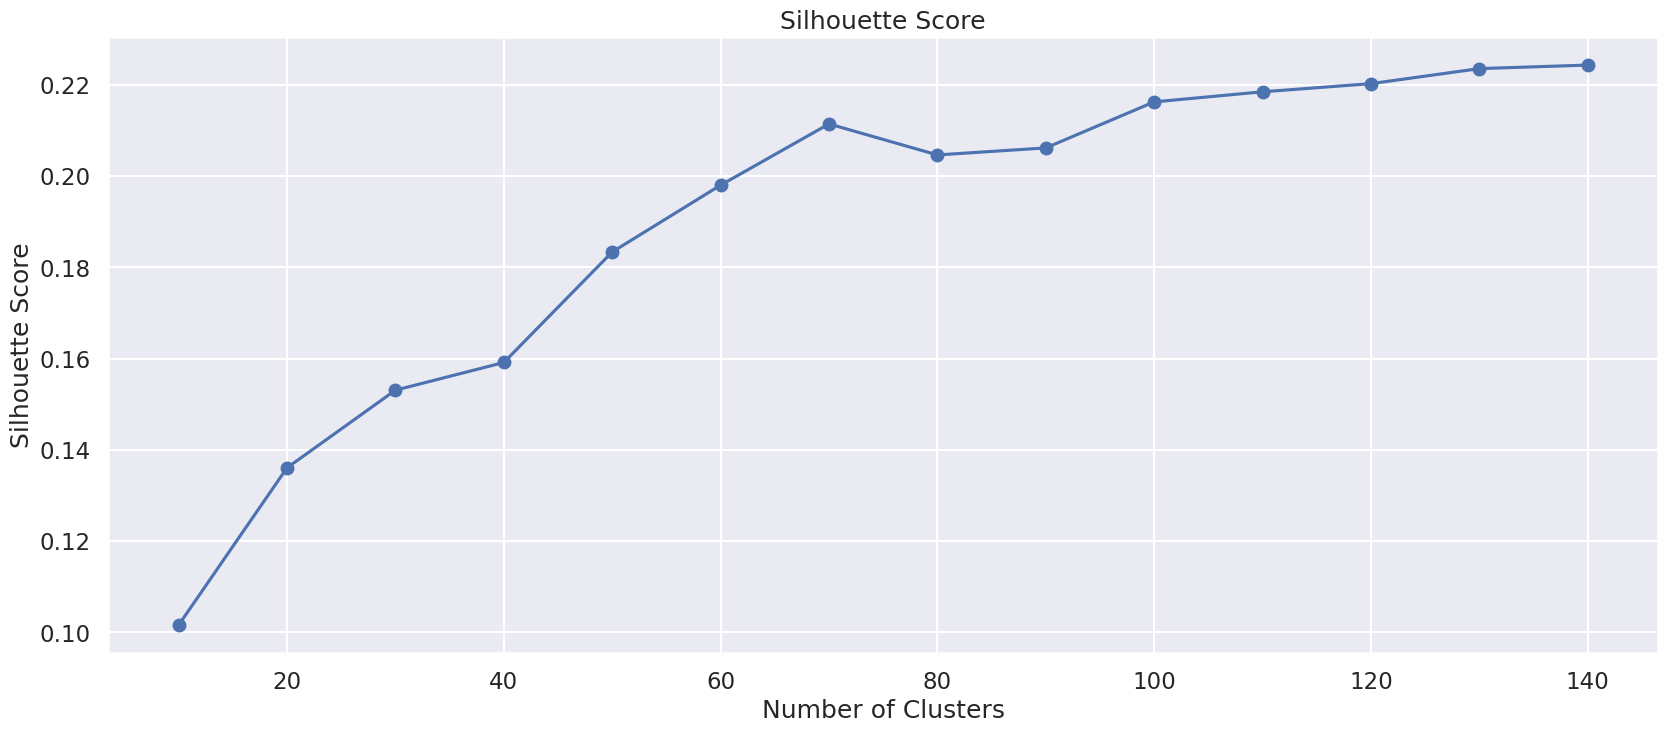

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(n_clusters, scores, marker="o")
ax.set_title("Silhouette Score")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score");

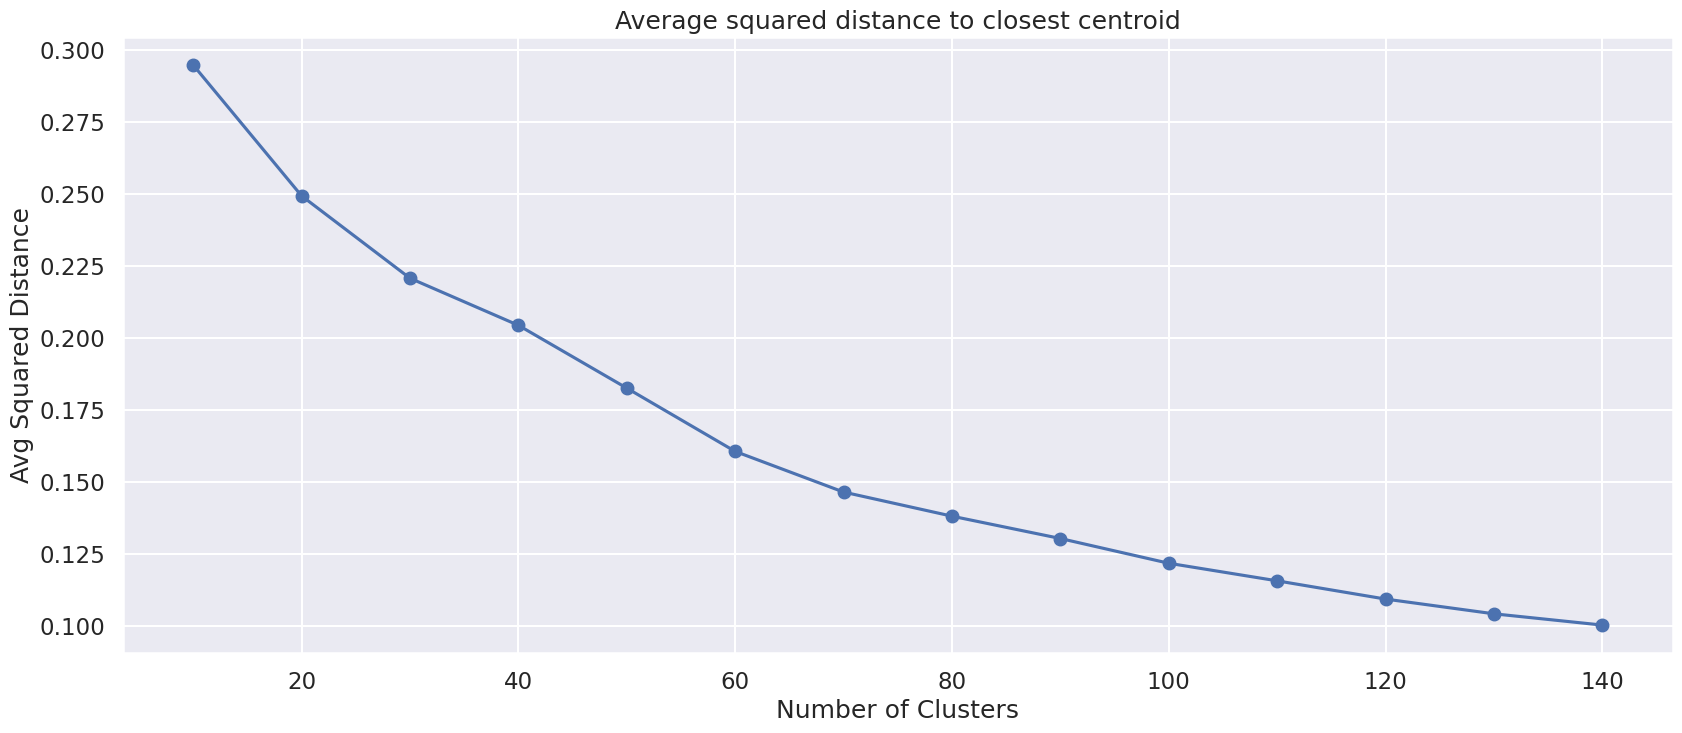

In [35]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(n_clusters, squared_dist_scores, marker="o")
ax.set_title("Average squared distance to closest centroid")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Avg Squared Distance");

Based on the above it appears that after about 70 clusters there is a diminishing return on improvemnent in the scores.  Therefore 70 clusters will be created.

In [36]:
# refit KMeans with 70 clusters
kmeans = KMeans(
    n_clusters=70,
    n_init="auto",
    random_state=41,
)

labels = kmeans.fit_predict(X_new)

In [37]:
# since we are only going to recommend articles that have been interacted with, we will use the created labels (predictions)
# and join them in with the df dataframe that contains the article IDs and user interactions.

# Note: not all articles with interaction appear to be in the df_content dataframe.
# This means that during the join those unmatched articles in df will be dropped for purposes of making recommendations based on clusters

# add labels to df_content
df_content["labels"] = labels

# join those into df
df["article_id"] = df["article_id"].astype("int64")
df_w_labels = df.merge(df_content, on="article_id", how="inner")

In [38]:
# examine new shape
# df_w_labels contains all user-article interactions and also contains the doc body and cluster labels
df_w_labels.shape

(21454, 8)

Examining some clusters to gauge effectiveness, cluster 5 looked interesting as the algorithm appears to have clustered similar articles together that come from the same publication.

This is nice to see as it gives some subjective validity to the created clusters!

In [39]:
df_w_labels[["title", "doc_full_name", "doc_description", "labels"]].loc[
    df_w_labels.labels == 5
].drop_duplicates()

,title,doc_full_name,doc_description,labels
104,"this week in data science (august 02, 2016)","This Week in Data Science (August 02, 2016)",Here’s this week’s news in Data Science and Bi...,5
151,this week in data science,This Week in Data Science,Learn about the latest Big Data University ann...,5
3012,"this week in data science (november 01, 2016)","This Week in Data Science (November 01, 2016)",Our thirty eighth release of a weekly round up...,5
5939,"this week in data science (july 26, 2016)","This Week in Data Science (July 26, 2016)",Here’s this week’s news in Data Science and Bi...,5
6705,"this week in data science (november 22, 2016)","This Week in Data Science (November 22, 2016)",Our forty first release of a weekly round up o...,5
6974,"this week in data science (december 27, 2016)","This Week in Data Science (December 27, 2016)",Our forty sixth release of a weekly round up o...,5
8415,"this week in data science (october 18, 2016)","This Week in Data Science (October 18, 2016)",Our thirty sixth release of a weekly round up ...,5


Now let's offer a new user some clusters to choose from.  10 Random clusters will be chosen (3 titles from each cluster). 
The user will then pick the 5 they are most interested in.

In [40]:
# pick 10 random clusters
# since some clusters were dropped during joining, need to make sure to only choose clusters that exist in df_w_labels

# get available clusters
available_clusters = list(set(df_w_labels["labels"].values))
clusters = np.random.choice(available_clusters, 10, replace=False)

# remove duplicates from df_w_labels for the selection step
unique_df_w_lables = df_w_labels[
    ["title", "doc_description", "labels"]
].drop_duplicates()


# display each cluster and 3 titles/descriptions from each cluster
print(
    "----Below are 10 different categories of articles with 3 articles from each category-------"
)
print("Choose 5 categories that look interesting to you.")
for cluster in clusters:
    print("------------------------------------\n")
    print(f"Category {cluster}")
    display(
        unique_df_w_lables[["title", "doc_description"]]
        .loc[unique_df_w_lables.labels == cluster]
        .head(3)
    )

----Below are 10 different categories of articles with 3 articles from each category-------
Choose 5 categories that look interesting to you.
------------------------------------

Category 22


,title,doc_description
7,dsx: hybrid mode,"In this series of tutorials, we’ll showcase th..."
133,machine learning for everyone,Today we take another step toward making Machi...
781,using machine learning to predict value of hom...,Data products have always been an instrumental...


------------------------------------

Category 67


,title,doc_description
27,building a business that combines human expert...,The O’Reilly Data Show podcast: Eric Colson on...
560,3992 using apache spark to predict attack v...,[A version of this post appears on the O’Reill...
1609,don’t overlook simpler techniques and algorithms,Even in areas and domains where deep learning ...


------------------------------------

Category 14


,title,doc_description
17,discover hidden facebook usage insights,Enrich unstructured data from Facebook using a...
57,520 using notebooks with pixiedust for fast...,Create a notebook using IBM Data Science Exper...
79,analyze traffic data from the city of san fran...,"Look at traffic data from the city, create rob..."


------------------------------------

Category 24


,title,doc_description
9,web picks - dataminingapps,"Every two weeks, we find the most interesting ..."
53,502 forgetting the past to learn the future...,Long Short-Term Memory neural networks (LSTM’s...
478,5 practical use cases of social network analyt...,This article gives you five examples which sho...


------------------------------------

Category 10


,title,doc_description
8,data science for real-time streaming analytics,"Listen to this podcast where Roger Rea, Senior..."
95,what is hadoop?,Dig into this breakdown of Hadoop components t...
137,data visualization playbook: telling the data ...,This data visualization playbook series can he...


------------------------------------

Category 47


,title,doc_description
40,quick guide to build a recommendation engine i...,This article explains the concept of recommend...
1353,recommendation system algorithms – stats and bots,"Today, many companies use big data to make sup..."
1384,recommender systems: approaches & algorithms,Most large-scale commercial and social website...


------------------------------------

Category 11


,title,doc_description
207,brunel in jupyter,Analytics and visualization often go hand-in-h...
717,detect malfunctioning iot sensors with streami...,Detect bad readings in real time using Python ...
1184,let's have some fun with nfl data,Working with Spark we will show data engineeri...


------------------------------------

Category 57


,title,doc_description
108,use spark r to load and analyze data,SparkR provides a distributed data frame API t...
354,self-service data preparation with ibm data re...,"If you are like most data scientists, you are ..."
390,"10 powerful features on watson data platform, ...",IBM Watson Data Platform offers the only colla...


------------------------------------

Category 5


,title,doc_description
104,"this week in data science (august 02, 2016)",Here’s this week’s news in Data Science and Bi...
151,this week in data science,Learn about the latest Big Data University ann...
3012,"this week in data science (november 01, 2016)",Our thirty eighth release of a weekly round up...


------------------------------------

Category 43


,title,doc_description
119,rapidly build machine learning flows with dsx,"Flows offer an interactive, graphical environm..."
9230,predict chronic kidney disease using spss mode...,In this blog post we will try to predict chron...
10388,using shell scripts to control data flows crea...,IBM Watson offers a collection of REST APIs fo...


In [41]:
def make_content_recs_new_user(df_w_labels, new_user_choices, m=10):
    """
    When a new user logs in, they will be presented with 3 random document titles and descriptions from 10 random clusters.
    They will then select 5 clusters that look interesting to them.
    The most interacted articles from those same 5 clusters will then be suggested for them as a recommendation.

    INPUT:
        df_w_labels: this is the pandas dataframe containing all article information and cluster labels.
                    Only articles with interactions are included and articles with multiple interactions will be duplicated.
        new_user_choices: list of the 5 clusters the user has shown interest in.
        m: the number of articles to return

    OUTPUT:
        recs: this will be a list of m article titles that are the most interacted articles from those 5 clusters

    """
    ids = get_top_article_ids(
        m, df=df_w_labels.loc[df_w_labels["labels"].isin(new_user_choices)]
    )
    recs = get_article_names(ids, df_w_labels)
    return recs

In [42]:
def make_content_rec_based_on_article_id(article_id, df_w_labels, m=10):
    """
    Make m content recommendations for a user who has read a specific article ID.
    This content recommendation will just be the most read articles from that article's cluster.
    """
    # get cluster of that specific article id
    cluster_label = df_w_labels.loc[
        df_w_labels["article_id"] == article_id, "labels"
    ].unique()[0]

    # drop the article the user has already read from the dataframe
    # this is because we don't want to recommend the same article back
    df_wo_user_article = df_w_labels.loc[df_w_labels["article_id"] != article_id]

    ids = get_top_article_ids(
        m, df=df_wo_user_article.loc[df_wo_user_article["labels"] == cluster_label]
    )
    recs = get_article_names(ids, df_w_labels)

    return recs

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

Method to prep the data:
* Create a tokenizer to transform the article bodies (doc_body) raw text into a matrix of TF-IDF features.
* Reduce the dimensionality of this matrix using a Truncated SVD transform.
* Apply KMeans clustering to this reduced dimensionality matrix.
* The clusters created via KMeans will be used to recommend documents from the same cluster.

Method for new user:
* When a new user logs in, they will be presented with 3 random document titles and descriptions from 10 random clusters.
* They will then select 5 clusters that look interesting to them.
* The most interacted articles from those same 5 clusters will then be suggested for them as a recommendation.

Method for someone who has interacted with a specific article:
* The person will be recommended to the top most interacted articles from the same cluster.


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [43]:
# make recommendations for a brand new user
# We'll just assume for simplicity that the user liked the first 5 categories identified in the above script.
# clusters are a list of the 10 cluster labels that were randomly shown to the new user
recs = make_content_recs_new_user(df_w_labels, clusters[:5], m=10)
print("---Content recommendations for a new user based on chosen clusters---\n")
pprint(recs)
print("\n")

# make a recommendations for a user who only has interacted with article id '270.0'
article_recs = make_content_rec_based_on_article_id(270, df_w_labels, m=10)
print(
    "---Content recommendations for a user who has interacted with article ID 270---\n"
)
pprint(article_recs)

---Content recommendations for a new user based on chosen clusters---

['discover hidden facebook usage insights',
 'building your first machine learning system ',
 'analyze traffic data from the city of san francisco',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'flightpredict ii: the sequel  – ibm watson data lab',
 '520    using notebooks with pixiedust for fast, flexi...\n'
 'Name: title, dtype: object',
 'real-time sentiment analysis of twitter hashtags with spark (+ pixiedust)',
 'i am not a data scientist – ibm watson data lab',
 'introducing ibm watson studio ',
 'using machine learning to predict value of homes on airbnb']


---Content recommendations for a user who has interacted with article ID 270---

['probabilistic graphical models tutorial\u200a—\u200apart 1 – stats and bots',
 'getting started with python',
 'how to map usa rivers using ggplot2',
 'markdown for jupyter notebooks cheatsheet',
 'a comparison of logistic regression and naive bayes ',
 'got zip code d

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [44]:
# Load the matrix here
user_item_matrix = pd.read_pickle("user_item_matrix.p")

In [45]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [46]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)  # use the built in to get the three matrices

**Provide your response here.**

The SVD technique works in this case because there are no null values here.  A user either interacted with an article or they didn't.  This is different from the lesson example as the lesson example actually required a user to enter a movie rating.  If there was no movie rating then the value was null and SVD does not work in the case of null values.

Also some comments below on the shapes of the matrices (for reference only):

In the lesson if the user-item matrix is shape n x k, where n = # of users and k = # of articles, then the SVD matrices should have shapes:
* u =  n x p  - where p = the number of latent features kept out of the total possible k, this matrix describes each users relationship to the latent features associated with the articles.
* s = p x p  - Sigma is always the same # of rows and columns as the # of latent factors that were kept.  The diagonal values help decide how many latent factors to keep.
* vt = p x k - Vt describes the latent feature / movie interaction effect.

Using the numpy formula yields the shapes of:
* u = n x n
* s = k (1d array)
* vt = k x k

These matrices would need to be reshaped to match the SVD matrix used in the lesson

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

/home/cb/miniconda3/envs/IBM/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

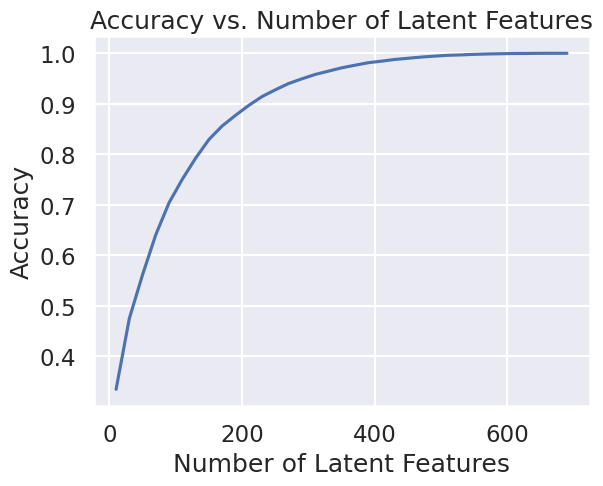

In [47]:
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df.shape[0])
plt.xlabel("Number of Latent Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Latent Features")

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [48]:
df_train = df.head(40000)
df_test = df.tail(5993)


def create_test_and_train_user_item(df_train, df_test):
    """
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids

    """
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test["user_id"].unique()
    test_arts = df_test["article_id"].unique()

    return user_item_train, user_item_test, test_idx, test_arts


user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(
    df_train, df_test
)

In [49]:
# 'How many users can we make predictions for in the test set?'
users_in_both = np.intersect1d(test_idx, df_train["user_id"].unique())
print(
    f"We can make predictions for {len(users_in_both)} users in the test set because that is the number of users who are in both the train and test set."
)

# 'How many users in the test set are we not able to make predictions for because of the cold start problem?'
users_wo_pred = len(test_idx) - len(users_in_both)
print(
    f"We cannot make predictions for {users_wo_pred} users because these users were not in the training set."
)

# 'How many articles can we make predictions for in the test set?'
articles_in_both = np.intersect1d(test_arts, df_train["article_id"].unique())
print(
    f"We can make predictions for {len(articles_in_both)} articles in the test set because that is the number of articles who are in both the train and test set."
)

# 'How many articles in the test set are we not able to make predictions for because of the cold start problem?'
articles_wo_pred = len(test_arts) - len(articles_in_both)
print(
    f"We cannot make predictions for {articles_wo_pred} articles in the test set because these articles were not in the training set."
)

We can make predictions for 20 users in the test set because that is the number of users who are in both the train and test set.
We cannot make predictions for 662 users because these users were not in the training set.
We can make predictions for 574 articles in the test set because that is the number of articles who are in both the train and test set.
We cannot make predictions for 0 articles in the test set because these articles were not in the training set.


In [50]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20
d = 0


sol_4_dict = {
    "How many users can we make predictions for in the test set?": c,  # letter here,
    "How many users in the test set are we not able to make predictions for because of the cold start problem?": a,  # letter here,
    "How many articles can we make predictions for in the test set?": b,  # letter here,
    "How many articles in the test set are we not able to make predictions for because of the cold start problem?": d,  # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [51]:
# fit SVD on the user_item_train matrix
# only keep the article columns that are in both matrices
user_item_train_selected_cols = user_item_train[articles_in_both]
u_train, s_train, vt_train = np.linalg.svd(user_item_train_selected_cols)

In [52]:
# Use these cells to see how well you can use the training
# decomposition to predict on test data

In [53]:
# From above, I found that the variable users_in_both are the user IDs that are both in the user_item_train & the user_item_test matrix
print(
    "Array of users in both train and test set. These are the user IDs which are also the index values of the pandas datafarme."
)
print(users_in_both)

Array of users in both train and test set. These are the user IDs which are also the index values of the pandas datafarme.
[2917 3024 3093 3193 3527 3532 3684 3740 3777 3801 3968 3989 3990 3998
 4002 4204 4231 4274 4293 4487]


In [54]:
# Find the corresponding numpy index.
def get_numpy_index_based_on_user_id(user_df, users_in_both=users_in_both):
    """
    This function will get the index location of the u_train or u_test matrix for the users thare in both.
    Input:
        user_df - Pandas dataframe.  Expects either the user_item_train or the user_item_test
        users_in_both - numpy array.  a numpy array which contains the user IDs that are contained in both train and test dataframes.

    Outputs:
        user_index - A numpy array containining the corresponding index in the u matrix where these users' data is.

    """
    user_index = user_df.index.get_indexer(users_in_both)
    return user_index

In [55]:
# get the indices for the users in both sets

train_indeces = get_numpy_index_based_on_user_id(user_item_train_selected_cols)
test_indeces = get_numpy_index_based_on_user_id(user_item_test)

In [56]:
# get only the users that are in both to create u_train_new, s_train_new, and vt_train_new
# also need to reshape data
u_train_new = u_train[train_indeces, : len(s_train)]
s_train_new = np.zeros((len(s_train), len(s_train)))
s_train_new[: len(s_train), : len(s_train)] = np.diag(s_train)

In [57]:
# Examine reshaped u_train and s_train
print("-----u_train_new--------")
print(f"Total shape is {u_train_new.shape}")
print("First 10 rows and 4 columns\n")
print(u_train_new[:10, :4])
print("\n")
print("-----s_train_new--------")
print(f"Total shape is {s_train_new.shape}")
print("first 5 rows and 5 columns\n")
print(s_train_new[:5, :5])
print("\n")
print("-----vt-----------------")
print(f"Total shape is {vt_train.shape}")
print("first 5 rows and 5 columns\n")
print(vt_train[:5, :5])

-----u_train_new--------
Total shape is (20, 574)
First 10 rows and 4 columns

[[-9.13836889e-03  1.05011318e-02  1.64170460e-05  1.05360851e-02]
 [-4.24717322e-02  8.81712398e-02  2.39322658e-02 -6.55528852e-03]
 [-1.08870302e-02  4.09224572e-02 -6.29518047e-03 -7.02200116e-03]
 [-2.27804234e-03  2.94297671e-03  5.89124862e-03  2.52119874e-02]
 [-4.70090762e-03  9.02373762e-04  2.87308395e-03 -2.24210210e-04]
 [-2.93923912e-02  4.18978632e-02  3.16136942e-02  1.18909974e-02]
 [-5.29802889e-02 -2.91960758e-02 -7.22159057e-03 -2.53288415e-03]
 [-1.82027357e-02  1.97820250e-02 -3.43668202e-03 -2.89206683e-03]
 [-1.01732647e-03  4.37255901e-03 -1.10355348e-03 -2.28698927e-03]
 [-1.68559954e-02  1.93308378e-02  7.38716415e-03  3.51047654e-02]]


-----s_train_new--------
Total shape is (574, 574)
first 5 rows and 5 columns

[[51.43582079  0.          0.          0.          0.        ]
 [ 0.         21.86811102  0.          0.          0.        ]
 [ 0.          0.         20.12597034  0.  

In [58]:
# filter the user_item_train and user_item_test to just the subset of both users
filtered_user_item_train = user_item_train_selected_cols.loc[users_in_both]
filtered_user_item_test = user_item_test.loc[users_in_both]

In [59]:
def predict(
    u,
    s,
    vt,
    latent_features_max=100,
    user_item_train=filtered_user_item_train,
    user_item_test=filtered_user_item_test,
):
    """
    Predict the test set for the 20 users based on the training data. Iterate over the number of latent features and measure the r2 score for each iteration.

    Inputs:
        u - This is the u_train_new which is the reshaped u_train filtered to just the 20 users that are in both training and test
        s - This is the s_train_new which is the reshaped s_train
        vt - This is the vt_train
        latent_features_max - (integer) Try from 1 latent feature up to latent_features_max.
        user_item_train - the filtered dataframe that contains only the 20 users in both training and test
        user_item_test - the fitlered dataframe that contains only the 20 users in both training and test

    Outputs:
        num_latent_features_list - A list of the number of latent features tested in each iteration.
        test_error_list - A list of the error between the test set and the prediction.
        test_r2_list - A list of the r2 scores for how well the test set was predicted
        train_error_list - A list of the error between the train set and the train prediction.
        train_r2_list = A list of the r2 scores for how well the model predicted the training data.
    """
    num_latent_features_list = []
    test_error_list = []
    test_r2_list = []
    train_error_list = []
    train_r2_list = []
    test_mean = np.mean(user_item_test)
    train_mean = np.mean(user_item_train)

    for k in np.arange(1, latent_features_max + 1, 1):
        u_k = u[:, :k]
        s_k = s[:k, :k]
        vt_k = vt[:k, :]

        pred = np.dot(np.dot(u_k, s_k), vt_k)

        # calculate diff between pred and actual
        squared_diff = np.square(np.array(user_item_test) - pred)  # for test set
        squared_diff_train = np.square(
            np.array(user_item_train) - pred
        )  # for train set

        # calculate the total error and append to error list for test set
        sum_square_errs = np.sum(np.sum(squared_diff))
        test_error_list.append(sum_square_errs)

        # calculate the total error and append to error list for train set
        sum_square_errs_train = np.sum(np.sum(squared_diff_train))
        train_error_list.append(sum_square_errs_train)

        # calculate r2 score
        r2_test = 1 - (
            sum_square_errs
            / np.sum(np.sum(np.square((np.array(user_item_test) - test_mean))))
        )  # for train
        r2_train = 1 - (
            sum_square_errs_train
            / np.sum(np.sum(np.square((np.array(user_item_train) - train_mean))))
        )
        test_r2_list.append(r2_test)
        train_r2_list.append(r2_train)

        # record number of latent features
        num_latent_features_list.append(k)

    return (
        num_latent_features_list,
        test_error_list,
        test_r2_list,
        train_error_list,
        train_r2_list,
    )


latent_features, test_errors, test_r2_scores, train_errors, train_r2_scores = predict(
    u_train_new, s_train_new, vt_train, latent_features_max=500
)

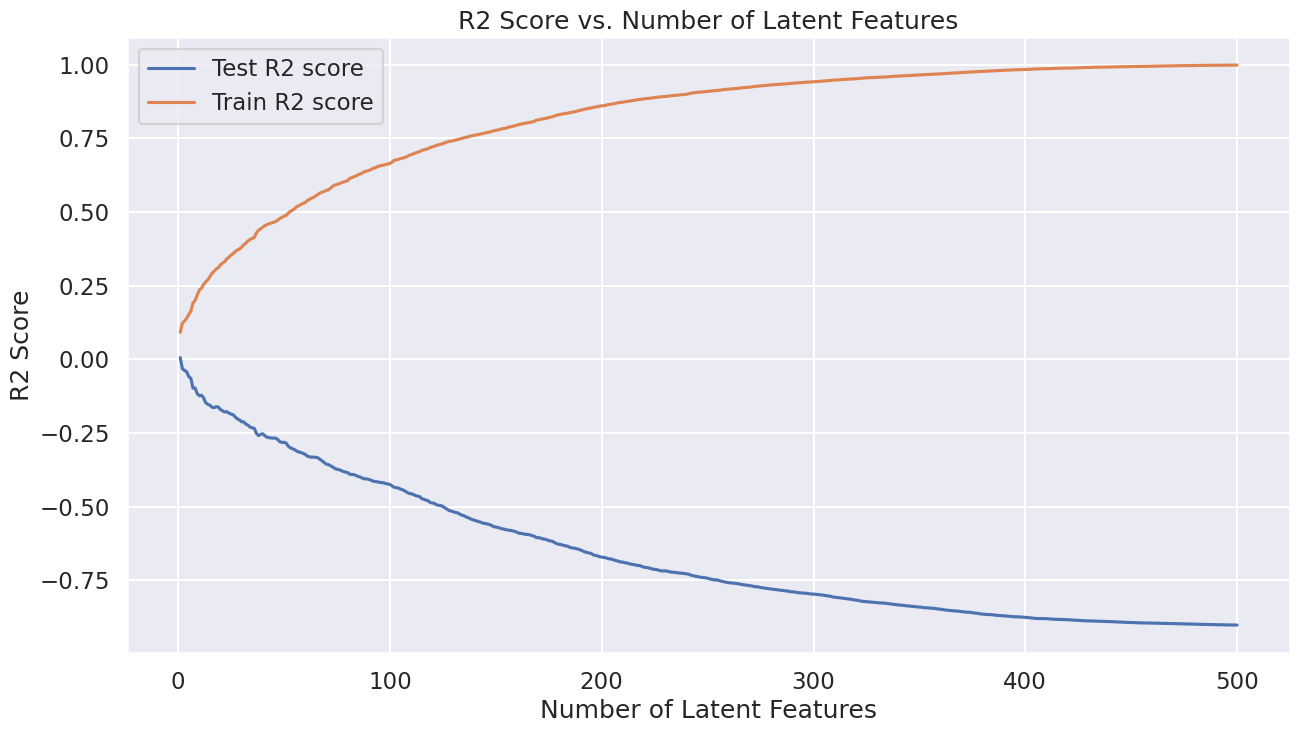

In [60]:
# plot accuracy
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x=latent_features, y=test_r2_scores, ax=ax, label="Test R2 score")
sns.lineplot(x=latent_features, y=train_r2_scores, ax=ax, label="Train R2 score")
ax.set_xlabel("Number of Latent Features")
ax.set_ylabel("R2 Score")
ax.set_title("R2 Score vs. Number of Latent Features");

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

The test errors and test r2 scores actually become worse with additional latent features.  Also, due to the fact that the test r2 scores are almost 100% negative (except for the first r2 score with 1 latent feature but that is effectively 0), this means that our model is not doing a better job predicting which articles a user may choose to interact with vs just using the mean as the prediction for the test set.

This is likely due to the fact that we have very low sample size, and the training data is also over-fitting for high numbers of latent features.

To test if this recommendation system would work in practice, I would suggest the following validation test:
* Perform an A/B test where some users get recommended a random article while other users are recommended an article using this recommendation engine.
* Then ask the user to rate the quality of the recommendation.
* It would then be possible to compare the quality score of the control group (random article) with the test group (recommendation engine article) to see if there is a statistical difference. 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [61]:
# from subprocess import call
# call(["python", "-m", "nbconvert","Recommendations_with_IBM.ipynb","--to html"])
!python -m nbconvert --to 'html' Recommendations_with_IBM.ipynb

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 511542 bytes to Recommendations_with_IBM.html
